# **FLUXO DE MODELAGEM: ALGORITMOS DE CLASSIFICAÇÃO BINÁRIA**
### *Exemplo: Recompra em e-Commerce*
##### *Este script resume a sequência de passos principais para modelagem de classificação binária utilizando os algoritmos vistos em aula. Apesar de genérico, é possível que ajustes precisem ser realizados a depender das nuances da base de dados.*



### Instalação de bibliotecas

In [1]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
# ! pip install shap

### Carregamento de bibliotecas

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler                       # Balanceamento de classes
from sklearn.compose import make_column_selector, ColumnTransformer          # Transformação e seleção de variáveis
from sklearn.preprocessing import StandardScaler, OneHotEncoder              # Padronização de quantitativas e criação de dummies para qualitativas
from sklearn.linear_model import LogisticRegression                          # Regressão logística
from sklearn.tree import DecisionTreeClassifier                              # Árvore de decisão
from sklearn.ensemble import RandomForestClassifier                          # Floresta aleatória
from sklearn.ensemble import AdaBoostClassifier                              # AdaBoost
from sklearn.ensemble import GradientBoostingClassifier                      # Gradient boosting
from xgboost import XGBClassifier                                            # XGBoost
from lightgbm import LGBMClassifier                                          # LightGBM
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate   # Validação cruzada
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV         # Otimização de hiperparâmetros via grid search e random search
import shap                                                                  # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [3]:
# Leitura da base de dados (altere os separadores de coluna e de decimal, conforme a necessidade)
dados = pd.read_table("../Dados/Recompra_eCommerce.txt",
                      decimal = ".",
                      sep = "\t")

### Verificação de tipos das variáveis da base de dados

In [4]:
pd.DataFrame(dados.dtypes)

,0
ID_CLIENTE,int64
IDADE,int64
VALOR_COMPRA_SITE,float64
QTDE_ITENS_COMPRA_SITE,int64
FLAG_ACESSORIOS_COMPRA_SITE,int64
FLAG_FEMININA_COMPRA_SITE,int64
FLAG_MASCULINA_COMPRA_SITE,int64
NOTA_SATISF_COMPRA_SITE,int64
FLAG_COMPROU_LOJA_FISICA_6M,int64
QTDE_COMPRAS_LOJA_FISICA_6M,int64


### Alteração de tipos de variáveis, se necessário
##### Variáveis quantitativas devem ser armazenadas como **float64** (com decimais) ou **int64** (inteiras). Já variáveis qualitativas costumam ser representadas como **bool** (binárias), **object** (categóricas) ou **category** (categóricas, com otimização de memória).

In [5]:
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('int64')
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('float64')
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('bool')
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('object')
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('category')

### Visualização da base de dados

In [6]:
display(dados)

,ID_CLIENTE,IDADE,VALOR_COMPRA_SITE,QTDE_ITENS_COMPRA_SITE,FLAG_ACESSORIOS_COMPRA_SITE,FLAG_FEMININA_COMPRA_SITE,FLAG_MASCULINA_COMPRA_SITE,NOTA_SATISF_COMPRA_SITE,FLAG_COMPROU_LOJA_FISICA_6M,QTDE_COMPRAS_LOJA_FISICA_6M,QTDE_ITENS_LOJA_FISICA_6M,FLAG_RECOMPRA_PROX_3_MESES
0,1,29,185.5,2,0,1,0,7,1,4,4,1
1,2,27,215.5,2,0,1,1,7,1,2,2,1
2,3,29,106.4,4,0,1,0,10,1,1,5,1
3,4,18,140.2,1,0,1,0,8,1,1,4,0
4,5,24,72.9,2,0,1,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1269,1270,40,165.9,6,0,1,0,8,1,3,9,1
1270,1271,33,55.6,1,0,1,0,9,0,0,0,0
1271,1272,28,105.7,4,0,0,1,6,0,0,0,0
1272,1273,28,284.9,3,0,1,1,8,0,0,0,0


### Tratamento de valores ausentes nas variáveis explicativas
##### Apesar de algoritmos baseados em árvores lidarem bem com valores ausentes por natureza, algumas implementações como o *AdaBoostClassifier* e o *GradientBoostingClassifier* requerem o preenchimento preliminar de valores ausentes para funcionarem. Com base em análise exploratória prévia, sugere-se categorizar as variáveis quantitativas que contiverem valores ausentes, mantendo uma categoria à parte 'Ausente'. Obs.: a imputação simples a partir da média ou mediana da variável não é uma boa escolha na maioria das situações.

In [7]:
# Exemplo de criação de uma variável fictícia "VAR_COM_MISSINGS_CAT", a partir de uma variável original "VAR_COM_MISSINGS",
# categorizada em decis (valores empatados permanecem em uma mesma categoria)
# dados['VAR_COM_MISSINGS_CAT'] = pd.qcut(dados['VAR_COM_MISSINGS'].dropna(), 10, duplicates = "drop")

In [8]:
# Tabela de frequências da variável tratada, com categoria apartada para valores ausentes
# dados['VAR_COM_MISSINGS_CAT'].value_counts(dropna = False)

### Separação de features e target

In [9]:
X = dados.drop(columns = ['FLAG_RECOMPRA_PROX_3_MESES', 'ID_CLIENTE']) # Remover variável target, variáveis chave, variáveis auxiliares ou que foram substituídas por variáveis já tratadas
y = dados['FLAG_RECOMPRA_PROX_3_MESES'] # Variável target

### Cópias das features e target
##### Criação de cópias dos objetos X e y, para preservá-los em caso de redução da base de desenvolvimento do modelo

In [10]:
X_sample = X
y_sample = y

### Balanceamento de base de dados (undersampling) e redução do tamanho da amostra, se necessário
##### Caso haja forte desbalanceamento entre as frequências das categorias da variável *target*, o balanceamento pode ajudar a proporcionar maior taxa de acerto em categorias minoritárias. Caso a base de dados seja grande mesmo após undersampling, pode-se selecionar uma sub-amostra ainda menor, para acelerar o processamento.

In [11]:
# Contagem de valores na variável resposta antes do balanceamento/redução
y.value_counts()

1    671
0    603
Name: FLAG_RECOMPRA_PROX_3_MESES, dtype: int64

In [12]:
# Balanceamento de base de dados via undersampling; caso seja necessário reduzir ainda mais o tamanho da amostra, escolha os tamanhos no argumento 'sampling_strategy'
# rus = RandomUnderSampler(sampling_strategy = {0: 500, 1: 500}, random_state = 123)
# X_sample, y_sample = rus.fit_resample(X_sample, y_sample)

In [13]:
# Contagem de valores na variável resposta após o balanceamento/redução
y_sample.value_counts()

1    671
0    603
Name: FLAG_RECOMPRA_PROX_3_MESES, dtype: int64

### Pré-processamento de variáveis explicativas: padronização e criação de dummies
##### Nesta etapa, pode-se **padronizar** as variáveis quantitativas (note que a padronização não é necessária para regressões ou modelos baseados em árvores) e deve-se **criar colunas dummies** para as variáveis qualitativas.

In [14]:
# Pré-processamento automático, com base nos tipos das variáveis
pre_processamento = ColumnTransformer(
    transformers = [
        # ('num', StandardScaler(), make_column_selector(dtype_include = ['int64', 'float64'])),
        ('cat', OneHotEncoder(drop = 'first'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

### Lista de algoritmos e hiperparâmetros testados via *grid search*
##### Execute a próxima célula apenas se quiser otimizar via *grid search*

In [15]:
# Lista de algoritmos e hiperparâmetros testados (altere os valores conforme a necessidade)
modelos = {
    'REGRESSÃO LOGÍSTICA': (LogisticRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [10, 20, 50, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [10, 20, 50, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5]
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [10, 20, 50, 100]
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0, 0.1, 0.5, 1]
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_data_in_leaf': [10, 20, 50, 100]
    })
}

### Lista de algoritmos e hiperparâmetros testados via *random search*
##### Execute a próxima célula apenas se quiser otimizar via *random search*

In [16]:
# Lista de algoritmos e hiperparâmetros testados (altere os valores conforme a necessidade)
modelos = {
    'REGRESSÃO LOGÍSTICA': (LogisticRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(10, 101),
        'max_depth': np.arange(2, 11)
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(10, 101),
        'max_depth': np.arange(2, 11)
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01)
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_samples_leaf': np.arange(10, 101)
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_child_weight': np.arange(1, 11),
        'gamma': np.arange(0, 1.1, 0.1)
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_data_in_leaf': np.arange(10, 101)
    })
}

### Estimativa de desempenho por meio de validação cruzada aninhada

In [17]:
# Aplicação do pré-processamento
X_transformed = pre_processamento.fit_transform(X)
X_sample_transformed = X_transformed[X_sample.index]

In [18]:
# Auxiliares para armazenamento do melhor modelo
melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

In [19]:
# Quantidade de folds nas camadas interna e externa (substitua KFold por StratifiedKFold se necessário)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [20]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

  # Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_AUC']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_AUC'])

  # Resultados
  # Observação: os cálculos de acurácia balanceada e sensibilidade consideram ponto de corte = 0,50 por padrão; logo, só devem ser considerados para bases balanceadas
  print(f'--- {nome} ---')
  print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
  print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))
  print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
  print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))
  print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
  print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- REGRESSÃO LOGÍSTICA ---
Média de AUC: 0.856
D.P. de AUC: 0.019
Média de Acurácia Balanceada: 0.777
D.P. de Acurácia Balanceada: 0.017
Média de Sensibilidade: 0.799
D.P. de Sensibilidade: 0.027

--- ÁRVORE DE DECISÃO ---
Média de AUC: 0.882
D.P. de AUC: 0.021
Média de Acurácia Balanceada: 0.809
D.P. de Acurácia Balanceada: 0.025
Média de Sensibilidade: 0.825
D.P. de Sensibilidade: 0.038

--- FLORESTA ALEATÓRIA ---
Média de AUC: 0.902
D.P. de AUC: 0.015
Média de Acurácia Balanceada: 0.827
D.P. de Acurácia Balanceada: 0.015
Média de Sensibilidade: 0.867
D.P. de Sensibilidade: 0.027

--- ADABOOST ---
Média de AUC: 0.897
D.P. de AUC: 0.013
Média de Acurácia Balanceada: 0.819
D.P. de Acurácia Balanceada: 0.014
Média de Sensibilidade: 0.891
D.P. de Sensibilidade: 0.035

--- GRADIENT BOOSTING ---
Média de AUC: 0.905
D.P. de AUC: 0.013
Média de Acurácia Balanceada: 0.825
D.P. de Acurácia Balanceada: 0.019
Média de Sensibilidade: 0.863
D.P. de Sensibilidade: 0.029

--- XGBOOST ---
Média de A

### Ajuste de modelo final na base de desenvolvimento, usando validação cruzada



In [21]:
# Quantidade de folds (substitua KFold por StratifiedKFold se necessário)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)

In [22]:
# Métricas de interesse
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

In [23]:
# Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
# modelo_final = GridSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

Melhores hiperparâmetros para LIGHTGBM: {'n_estimators': 20, 'min_data_in_leaf': 64, 'max_depth': 7, 'learning_rate': 0.24000000000000002}


### Importância das features do modelo final

In [24]:
# Auxiliar: nomes das features após pré-processamento
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_qualitativas) + list(features_quantitativas)

In [36]:
importancias

array([ 50, 104,  15,  14,   0,  10,  37,  19,   4,  21])

In [25]:
# Cálculo de medida de importância de Gini
importancias = modelo_final.best_estimator_.feature_importances_

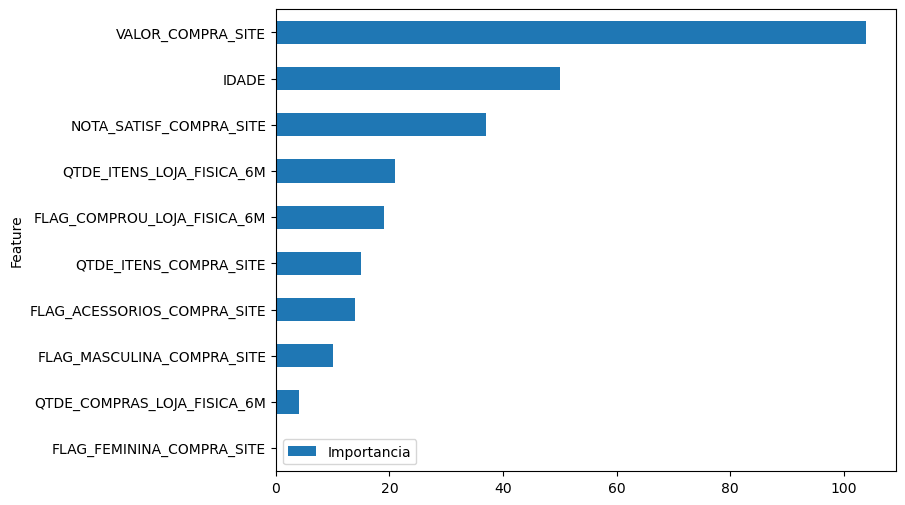

In [26]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [27]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(modelo_final.best_estimator_)
valores_shap = explainer(X_sample_transformed)

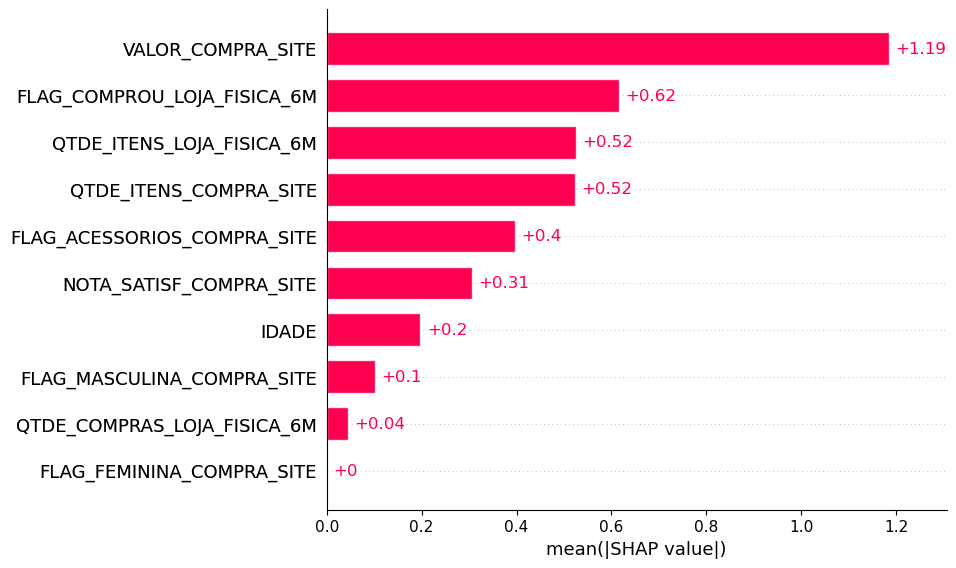

In [28]:
# Gráfico do SHAP absoluto médio por feature
if melhor_algoritmo == 'ÁRVORE DE DECISÃO' or melhor_algoritmo == 'FLORESTA ALEATÓRIA':
  shap.plots.bar(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))
else:
  shap.plots.bar(shap.Explanation(values = valores_shap, feature_names = features))

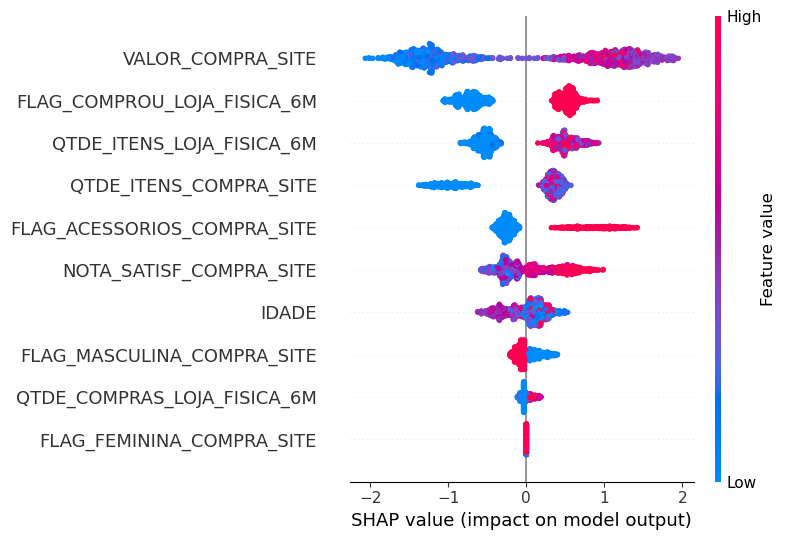

In [29]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
if melhor_algoritmo == 'ÁRVORE DE DECISÃO' or melhor_algoritmo == 'FLORESTA ALEATÓRIA':
  shap.summary_plot(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))
else:
  shap.summary_plot(shap.Explanation(values = valores_shap, feature_names = features))

### Aplicação de modelo final na base completa (caso tenha havido redução da base para a modelagem)



In [30]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = modelo_final.best_estimator_.predict_proba(X_transformed)[:,1]

In [31]:
# Definição de ponto de corte
ponto_corte = y_sample.astype(int).mean()

In [32]:
# Atribuição da categoria predita
dados['y_pred'] = (y_prob >= ponto_corte).astype(int)

In [33]:
# Tabela de classificação: real vs. predito (frequências absolutas)
pd.crosstab(y, dados['y_pred'])

y_pred,0,1
FLAG_RECOMPRA_PROX_3_MESES,,
0,510,93
1,83,588


In [34]:
# Tabela de classificação: real vs. predito (frequências relativas)
pd.crosstab(y, dados['y_pred'], normalize = 'index').round(3) * 100

y_pred,0,1
FLAG_RECOMPRA_PROX_3_MESES,,
0,84.6,15.4
1,12.4,87.6


### Aplicação de modelo final em outra base (por exemplo, para validação out of time)

In [35]:
# Leitura da nova base de dados (altere os separadores de coluna e de decimal, conforme a necessidade)
novos_dados = pd.read_table("Recompra_eCommerce.txt",
                            decimal = ".",
                            sep = "\t")

FileNotFoundError: [Errno 2] No such file or directory: 'Recompra_eCommerce.txt'

In [ ]:
# Verificação de tipos das variáveis da voca base de dados
novos_dados.dtypes

In [ ]:
# Alteração de tipos de variáveis, se necessário (devem ser realizadas as mesmas alterações aplicadas na base de desenvolvimento)
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('int64')
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('float64')
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('bool')
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('object')
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('category')

In [ ]:
# Visualização da base de dados
display(novos_dados)

In [ ]:
# Tratamento de valores ausentes nas variáveis explicativas (EXEMPLO)
# dados['VAR_COM_MISSINGS_CAT'] = pd.qcut(dados['VAR_COM_MISSINGS'].dropna(), 10, duplicates = "drop")
# dados['VAR_COM_MISSINGS_CAT'].value_counts(dropna = False)

In [ ]:
# Separação de features e target
X = novos_dados.drop(columns = ['FLAG_RECOMPRA_PROX_3_MESES', 'ID_CLIENTE']) # Remover variável target, variáveis chave ou outras variáveis meramente auxiliares
y = novos_dados['FLAG_RECOMPRA_PROX_3_MESES'] # Variável target

In [ ]:
# Aplicação do pré-processamento
X_transformed = pre_processamento.fit_transform(X)

In [ ]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = modelo_final.best_estimator_.predict_proba(X_transformed)[:,1]

In [ ]:
# Definição de ponto de corte
ponto_corte = y_sample.astype(int).mean()

In [ ]:
# Atribuição da categoria predita
novos_dados['y_pred'] = (y_prob >= ponto_corte).astype(int)

In [ ]:
# Tabela de classificação: real vs. predito (frequências absolutas)
pd.crosstab(y, novos_dados['y_pred'])

In [ ]:
# Tabela de classificação: real vs. predito (frequências relativas)
pd.crosstab(y, novos_dados['y_pred'], normalize = 'index').round(3) * 100